![Colegio Bourbaki](./Images/Bourbaki.png)

## Machine Learning & AI

## Redes Convolucionales: Detección de objetos

### Contexto

Airbus se complace en desafiar a los Kagglers a construir un modelo que detecte todos los barcos en imágenes de satélite lo más rápidamente posible.

**¿Puedes encontrarlos incluso en imágenes con nubes o bruma?**

Esta es la historia: El tráfico marítimo crece rápidamente. Un mayor número de buques aumenta las posibilidades de que se produzcan infracciones en el mar, como accidentes navales devastadores para el medio ambiente, piratería, pesca ilegal, tráfico de drogas y movimiento ilegal de mercancías. Esto ha obligado a muchas organizaciones, desde organismos de protección del medio ambiente hasta compañías de seguros y autoridades gubernamentales nacionales, a vigilar más de cerca los mares abiertos.

Airbus ofrece servicios integrales de vigilancia marítima mediante la creación de una solución significativa para una amplia cobertura, detalles finos, vigilancia intensiva, reactividad de primera calidad y respuesta de interpretación. Combinando sus datos patentados con analistas altamente cualificados, ayudan al sector marítimo a aumentar sus conocimientos, anticiparse a las amenazas, activar alertas y mejorar la eficiencia en el mar.
 
Si están interesados en explorar más datos de Airbus, le invitamos a visitar OneAtlas Sandbox. Y para más información sobre las capacidades de vigilancia echen un vistazo a la página de Airbus Intelligence (https://intelligence.airbus.com/industries/maritime/)

Info de los datos en: https://www.kaggle.com/competitions/airbus-ship-detection

### Descripción

En este concurso, deberán localizar barcos en imágenes y colocar un segmento de cuadro delimitador alineado alrededor de los barcos que localice. Muchas imágenes no contienen barcos, y las que sí los contienen pueden ser múltiples. 

Los barcos dentro de una misma imagen y entre imágenes pueden diferir en tamaño (a veces significativamente) y estar situados en mar abierto, en muelles, puertos deportivos, etc.

Para esta métrica, los segmentos de objetos no pueden solaparse. Hubo un pequeño porcentaje de imágenes, tanto en el conjunto de imágenes de prueba como en el de entrenamiento, en las que se produjo un ligero solapamiento de segmentos de objetos cuando los barcos estaban directamente uno al lado del otro. Cualquier superposición de segmentos se eliminó ajustándolos a la codificación de fondo (es decir, sin barco). Por lo tanto, algunas imágenes tienen una verdad de fondo que puede ser un cuadro delimitador alineado con algunos píxeles eliminados de un borde del segmento. Estos pequeños ajustes tendrán un impacto mínimo en la puntuación, ya que ésta se evalúa sobre umbrales de solapamiento crecientes.

El archivo train_ship_segmentations.csv proporciona la verdad básica (en formato de codificación run-length [RLE]) para las imágenes de entrenamiento. Los archivos sample_submission contienen las imágenes de prueba.

### Librerías

In [1]:
# Plotting
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
from skimage.morphology import label

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.amp import autocast, GradScaler
from torch.utils.data import DataLoader, Dataset

# Utils
import os
import sys
import random
import numpy as np
import pandas as pd
from dataclasses import dataclass
from torchsummary import summary
from tqdm import tqdm

### Configuraciones

In [2]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
!set 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:2'
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.cuda.empty_cache()
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
print("__Python VERSION:", sys.version)
print("__pyTorch VERSION:", torch.__version__)
print(
    "__CUDA VERSION",
)
! nvidia-smi
print("__CUDNN VERSION:", torch.backends.cudnn.version())
!nvcc --version
print("__Number CUDA Devices:", torch.cuda.device_count())
print("__Devices")
print("Active CUDA Device: GPU", torch.cuda.current_device())
print("Available devices ", torch.cuda.device_count())
print("Current cuda device ", torch.cuda.current_device())

__Python VERSION: 3.11.9 (main, Jun 13 2024, 16:50:48) [GCC 11.4.0]
__pyTorch VERSION: 2.4.0+cu124
__CUDA VERSION
Thu Aug 29 18:57:34 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti     Off |   00000000:01:00.0  On |                  N/A |
| N/A   60C    P5              8W /   50W |     120MiB /   4096MiB |     37%      Default |
|                         

Si desean puede hacer un muestro del dataset original, pero primero veamos su composición original:

In [4]:
# Path to the directory you want to check
directory_path = [
    "./Data/train_v2",
    "./Data/test_v2",
    #"./Data/train_v2_sampled",
    #"./Data/test_v2_sampled",
]

# List of common image file extensions
image_extensions = [".jpg", ".jpeg", ".png", ".gif", ".bmp"]

# Loop through all files in the directory
for dir in directory_path:
    # Initialize a counter
    image_count = 0
    for file in os.listdir(dir):
        # Check if the file is an image
        if any(file.lower().endswith(ext) for ext in image_extensions):
            image_count += 1
    print(f"Number of images in the directory {dir}: {image_count}")

Number of images in the directory ./Data/train_v2: 192556
Number of images in the directory ./Data/test_v2: 15606


Vamos a leer el archivo de datos:

In [5]:
df = pd.read_csv("./Data/train_ship_segmentations_v2.csv")

In [6]:
df

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN


In [7]:
print(df.shape[0], "masks found")
print(len(df["ImageId"].unique()), "unique images found")

231723 masks found
192556 unique images found


Vamos a chequear las dimensiones de las imágenes:

In [8]:
# Path to your image file
image_path = f"./Data/train_v2/{df['ImageId'][0]}"

# Open the image
image = Image.open(image_path)

# Get the size of the image
width, height = image.size

# Get the mode of the image to determine the number of channels
mode = image.mode

# Map the common modes to the number of channels
channel_map = {
    "1": 1,  # (1-bit pixels, black and white, stored with one pixel per byte)
    "L": 1,  # (8-bit pixels, black and white)
    "P": 1,  # (8-bit pixels, mapped to any other mode using a color palette)
    "RGB": 3,  # (3x8-bit pixels, true color)
    "RGBA": 4,  # (4x8-bit pixels, true color with transparency mask)
    "CMYK": 4,  # (4x8-bit pixels, color separation)
    "YCbCr": 3,  # (3x8-bit pixels, color video format)
    "LAB": 3,  # (3x8-bit pixels, the L*a*b color space)
    "HSV": 3,  # (3x8-bit pixels, Hue, Saturation, Value color space)
    "I": 1,  # (32-bit signed integer pixels)
    "F": 1,  # (32-bit floating point pixels)
}

# Get the number of channels
num_channels = channel_map.get(mode, "Unknown")

# Print the size and number of channels
print(f"Image dimensions (W x H x C) : {width} x {height} x {num_channels}")

Image dimensions (W x H x C) : 768 x 768 x 3


Veamos alguna de las imágenes:

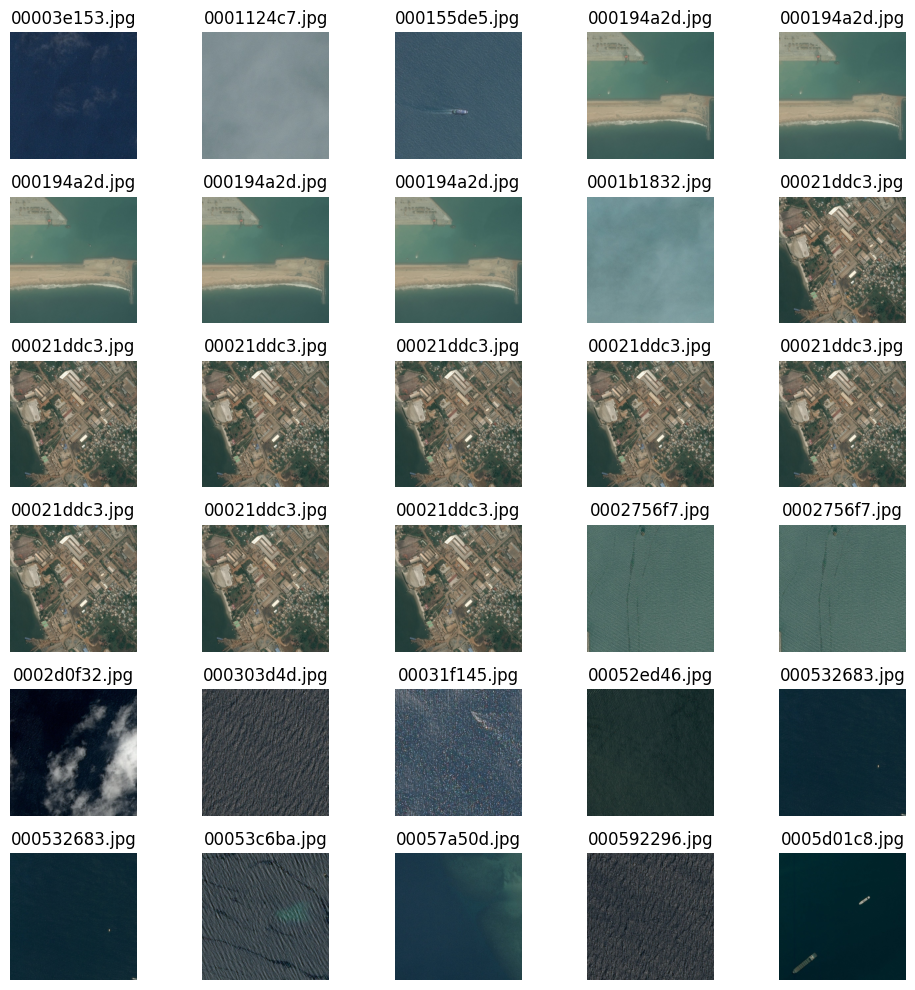

In [9]:
fig, axes = plt.subplots(6, 5, figsize=(10, 10))

# Flatten the array of axes to easily iterate over it
axes_flat = axes.flatten()

for i in range(30):
    image_id = df["ImageId"][i]
    image_path = f"./Data/train_v2/{image_id}"
    image = Image.open(image_path)
    axes_flat[i].imshow(image)
    axes_flat[i].axis("off")  # Hide the axes ticks
    axes_flat[i].set_title(image_id)

plt.tight_layout()
plt.show()

In [10]:
images_train = np.array(os.listdir("./Data/train_v2"))

In [11]:
marks = df[df["ImageId"].isin(images_train)]
marks

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN


Veamos el enmascaramiento:

In [12]:
def mask_part(pic, width, height, num_channels):
    """
    Decodes a single ship mask from RLE to a numpy matrix.

    Parameters:
    - pic: RLE string.
    - width: Image width.
    - height: Image height.
    - num_channels: Number of mask channels, intended to be 3 for RGB masks.

    Returns:
    - Numpy array of the mask, shaped (height, width, num_channels).
    """
    back = np.zeros(width * height)  # Initialize a flat array for single-channel data
    starts = pic.split()[0::2]
    lens = pic.split()[1::2]
    for i in range(len(lens)):
        start = int(starts[i]) - 1
        end = start + int(lens[i])
        back[start:end] = 1
    single_channel_mask = np.reshape(
        back, (height, width)
    )  # Reshape to 2D single-channel mask

    # Expand the single-channel mask to 3 channels
    if num_channels == 3:
        three_channel_mask = np.stack((single_channel_mask,) * 3, axis=-1)
        return three_channel_mask
    else:
        # If num_channels is not 3, this would need to be adjusted accordingly
        return single_channel_mask[
            :, :, np.newaxis
        ]  # Add a new axis for the single channel

Esta función, llamada mask_part, toma una máscara codificada en formato Run-Length Encoding (RLE) y la decodifica para obtener una matriz de numpy que representa la máscara en formato de imagen, con posibilidad de tener uno o tres canales.

Parámetros:
* pic: Una cadena que contiene la máscara codificada en RLE. El formato RLE es una forma compacta de representar la máscara, donde los números indican los puntos de inicio y la longitud de las secuencias de píxeles que pertenecen a la máscara.
* width: El ancho de la imagen en píxeles.
* height: La altura de la imagen en píxeles.
* num_channels: El número de canales que tendrá la máscara en la salida. Normalmente se espera que sea 3 si la máscara se necesita en formato RGB.

In [13]:
def is_empty(key, marks_aux):
    """
    Function that checks if there is a ship in an image.

    Parameters:
    - key: The ImageId for the image to check.
    - marks_aux: A DataFrame containing the ImageId and mask information.

    Returns:
    - True if the image contains no ships, False otherwise.
    """
    df = marks_aux[marks_aux["ImageId"] == key].iloc[:, 1]
    # Check for empty or NaN values explicitly
    if df.isnull().all() or (len(df) == 1 and pd.isnull(df.iloc[0])):
        return True
    else:
        return False

La función is_empty tiene como propósito determinar si una imagen, identificada por un ImageId, contiene o no un barco basado en los datos proporcionados en un DataFrame llamado marks_aux.

Parámetros:
* key: El identificador único de la imagen (ImageId) que se desea verificar.
* marks_aux: Un DataFrame que contiene información sobre las imágenes, incluyendo el ImageId y los datos de la máscara que indican la presencia o ausencia de barcos en la imagen.

In [14]:
def masks_all(key, marks_aux, width, height, num_channels):
    """
    Merges all ship masks for a given image into one mask.

    Parameters:
    - key: Image ID.
    - marks_aux: DataFrame with Image IDs and RLE mask strings.
    - width: Image width.
    - height: Image height.
    - num_channels: Number of mask channels.

    Returns:
    - Composite mask as a numpy array.
    """
    df = marks_aux[marks_aux["ImageId"] == key].iloc[:, 1]
    masks = np.zeros((height, width, num_channels))
    if is_empty(key, marks_aux):
        return masks
    else:
        for mask_rle in df.dropna():
            masks += mask_part(mask_rle, width, height, num_channels)
        # Ensure masks don't exceed binary values after summation
        masks = np.clip(masks, 0, 1)
        return np.transpose(masks, (1, 0, 2))

La función masks_all se utiliza para combinar todas las máscaras de barcos correspondientes a una imagen específica en una única máscara compuesta. Esta función es particularmente útil en tareas de segmentación de imágenes donde una imagen puede tener múltiples barcos, y cada barco tiene su propia máscara

Parámetros:
* key: El identificador único de la imagen (ImageId) para la cual se desean combinar las máscaras.
* marks_aux: Un DataFrame que contiene los ImageId y las máscaras codificadas en formato RLE correspondientes.
* width: El ancho de la imagen en píxeles.
* height: La altura de la imagen en píxeles.
* num_channels: El número de canales de la máscara (por ejemplo, 3 para máscaras en formato RGB).

In [15]:
def draw(path, lista, marks, width, height, num_channels):
    num_images = len(lista)
    plt.figure(figsize=(10, 20))
    for i, image_id in enumerate(lista):
        # Images are located in './Data/train_v2/'
        img_path = f"{path}{image_id}"
        img = plt.imread(img_path)

        # Generate mask using masks_all with the specified dimensions
        mask = masks_all(image_id, marks, width, height, num_channels)

        # Plot image
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Image: {image_id}")

        # Assuming the mask returned by masks_all is correctly shaped, but adjust if needed
        # Plot mask
        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(
            mask.squeeze(), cmap="gray"
        )  # Use squeeze() to remove single-channel dimension for display
        plt.axis("off")
        plt.title(f"Mask for: {image_id}")

    plt.tight_layout()
    plt.show()

Randomly chosen images with corresponding masks


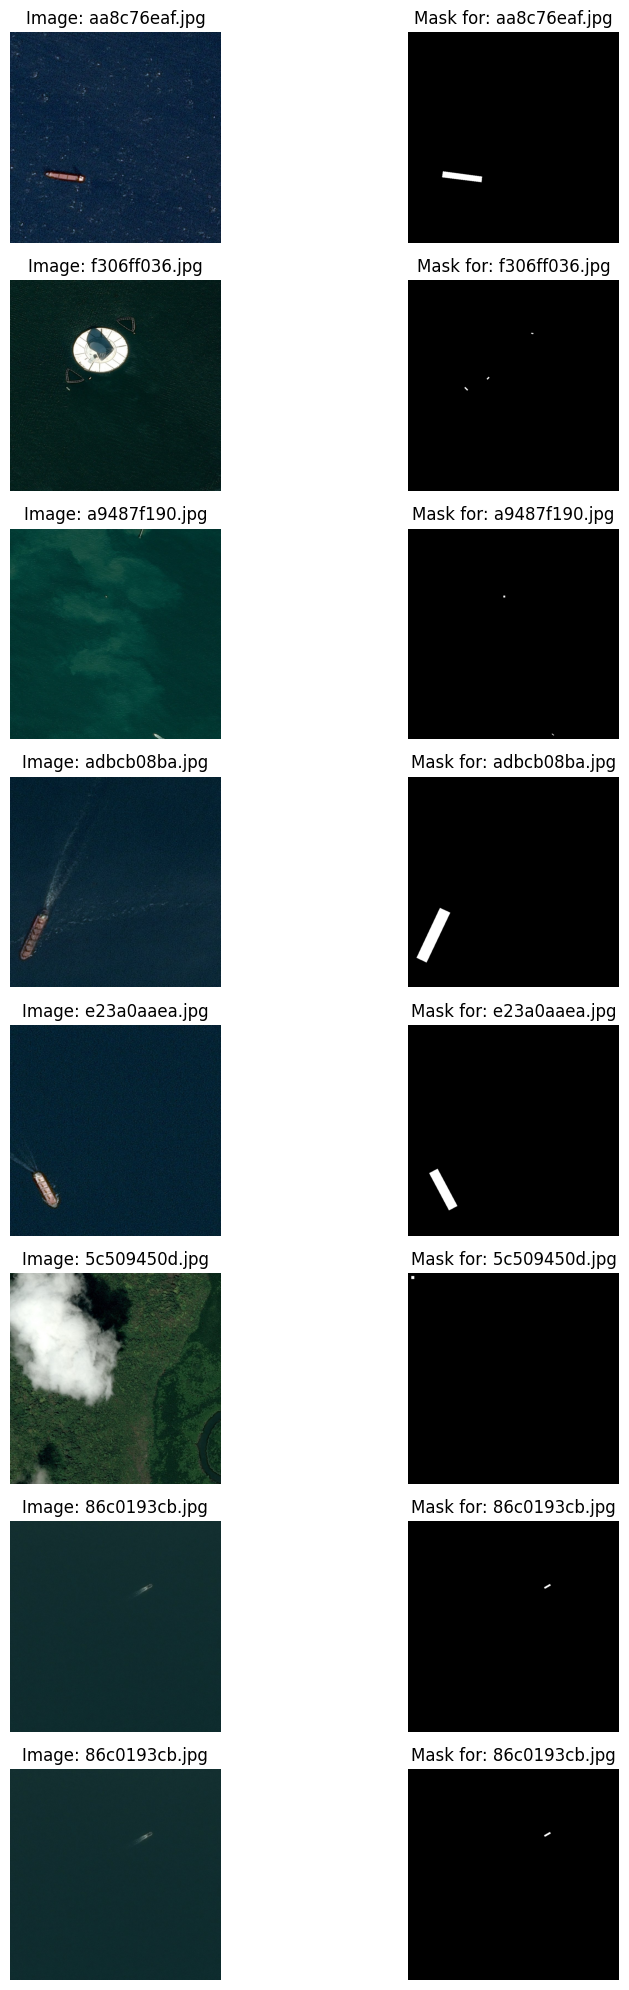

In [16]:
print("Randomly chosen images with corresponding masks")
draw(
    "./Data/train_v2/",
    np.random.choice([i for i in images_train[:100] if not is_empty(i, marks)], size=8),
    marks,
    width,
    height,
    num_channels,
)

### Modelo U-Net

Wiki: https://en.wikipedia.org/wiki/U-Net

Paper original: https://arxiv.org/abs/1505.04597

Arquictura U-Net:

La arquitectura UNet que se muestra en la imagen es un tipo de red neuronal convolucional (CNN) diseñada principalmente para tareas de segmentación de imágenes. A continuación, te explico cómo funciona la arquitectura basada en la imagen que proporcionaste:
1. Entrada

    La entrada es una imagen de tamaño 3×256×256, donde "3" es el número de canales (por ejemplo, RGB), y "256 x 256" es la dimensión espacial de la imagen.

2. Codificador (Encoder) - Contracción

    Down conv1 a Down conv4: La parte izquierda de la red (codificador o camino de contracción) tiene varias capas convolucionales seguidas de capas de max pooling. Estas capas extraen características de bajo nivel (bordes, texturas, etc.) y luego características más complejas a medida que se avanza en la red.
    Cada capa "Down conv" aplica una o más convoluciones seguidas de una función de activación (como ReLU) para aprender características de la imagen.
    Las capas de max pooling reducen las dimensiones espaciales de la imagen, reteniendo solo las características más importantes. Esto permite que la red capture características más abstractas y de mayor nivel.

3. Cuello de botella

    La última capa de "Down conv4" es la más profunda de la red y representa la capa de cuello de botella, donde la imagen está representada por un conjunto reducido de características muy abstractas.

4. Decodificador (Decoder) - Expansión

    Up conv1 a Up conv3: La parte derecha de la red (decodificador o camino de expansión) realiza el proceso inverso del codificador. Se utilizan capas de upsampling (que incrementan la dimensión espacial de los datos) seguidas de capas convolucionales para reconstruir la segmentación de la imagen original.
    Cada paso de upsampling aumenta la resolución de las características aprendidas, reconstruyendo gradualmente la imagen segmentada.
    Después de cada upsampling, se concatena (concat) con la correspondiente salida del codificador (a través de las conexiones directas entre las capas correspondientes de encoder y decoder). Esta concatenación permite que la red recupere detalles espaciales que se habrían perdido durante la fase de compresión.

5. Salida

    Finalmente, la red genera una máscara de segmentación de tamaño k×256×256k×256×256, donde "k" es el número de clases o categorías que la red está segmentando. Si es una tarea de segmentación binaria, k será 1.

Resumen

La UNet se caracteriza por sus conexiones de "skip" o saltos que van de las capas de contracción a las capas de expansión, permitiendo la recuperación de detalles finos perdidos durante la fase de compresión. Este tipo de arquitectura es muy eficaz para tareas donde se requiere segmentación precisa de los bordes, como en imágenes médicas.

![Colegio Bourbaki](./Images/UNet.png)

In [17]:
train_dpath = "./Data/train_v2/"
test_dpath = "./Data/test_v2/"
images_test = np.array(os.listdir(test_dpath))
original_img_size = (width, height)

In [18]:
@dataclass
class Params:
    img_size: tuple = (256, 256)  # You can try with (256, 256)
    bs: int = 32
    num_workers: int = 0  # chequeo en foro y discusiones el paralelismo
    lr: float = 0.0001
    epochs: int = 8
    unet_depth: int = 4
    unet_start_filters: int = 16
    pin_memory: bool = False
    channel_means: tuple = (0.5, 0.5, 0.5)
    channel_stds: tuple = (0.5, 0.5, 0.5)

In [19]:
def get_mask_encodings(annos, fnames):
    """
    Extracts run-length encoded masks for a specified set of images.

    Parameters:
    - annos: DataFrame containing 'ImageId' and 'EncodedPixels' columns.
    - fnames: Iterable of image filenames (IDs) to filter the annotations for.

    Returns:
    - Dictionary with image IDs as keys and lists of their mask encodings as values.
    """
    a = annos[annos["ImageId"].isin(fnames)]
    return a.groupby("ImageId")["EncodedPixels"].apply(lambda x: x.tolist()).to_dict()

La función get_mask_encodings tiene como objetivo extraer las máscaras codificadas en formato Run-Length Encoding (RLE) para un conjunto específico de imágenes. Esta función filtra un DataFrame de anotaciones para obtener solo las máscaras correspondientes a los identificadores de imagen proporcionados y las organiza en un diccionario.

Parámetros:
* annos: Un DataFrame que contiene al menos dos columnas: 'ImageId' y 'EncodedPixels'.
* ImageId: El identificador único de cada imagen.
* EncodedPixels: La cadena de caracteres que representa la máscara en formato RLE.
* fnames: Un iterable (por ejemplo, una lista o un conjunto) que contiene los nombres de archivo (o identificadores) de las imágenes para las que se desea extraer las máscaras.

In [20]:
def rle_decode(mask_rle, shape=original_img_size):
    """
    Decodes a run-length encoded string into a binary mask.
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(
        shape
    ).T  # Shape is (height, width) and needs transpose to match image orientation

La función rle_decode se utiliza para decodificar una cadena de caracteres en formato Run-Length Encoding (RLE) y convertirla en una máscara binaria que representa la presencia de un objeto (como un barco) en una imagen. El formato RLE es una forma compacta de representar áreas continuas en una imagen, útil en la compresión de máscaras de segmentación.

Parámetros:
* mask_rle: Una cadena que contiene la máscara codificada en formato RLE. Esta cadena describe las posiciones y longitudes de las secuencias de píxeles que forman el objeto en la imagen.
* shape: Una tupla que define las dimensiones de la imagen (altura y ancho) en la que se va a decodificar la máscara. El valor predeterminado es original_img_size, que debe ser una variable predefinida que contiene las dimensiones originales de la imagen.

In [21]:
def rle_encode(im):
    """
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    """
    pixels = im.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    runs[::2] -= 1
    return " ".join(str(x) for x in runs)

La función rle_encode toma una máscara binaria (donde 1 representa el objeto y 0 el fondo) y la convierte en una cadena codificada en formato Run-Length Encoding (RLE). Este formato RLE es una forma compacta de describir secuencias de píxeles consecutivos que pertenecen al objeto, lo cual es útil para reducir el tamaño de almacenamiento de las máscaras en tareas de segmentación de imágenes.

Parámetros:
* im: Un array de numpy que representa la máscara binaria de la imagen. Los valores 1 indican la presencia del objeto, y los valores 0 indican el fondo.

In [22]:
class ImgDataset(Dataset):
    def __init__(
        self,
        img_dpath,
        img_fnames,
        img_transform,
        mask_encodings=None,
        mask_size=None,
        mask_transform=None,
    ):
        self.img_dpath = img_dpath
        self.img_fnames = img_fnames
        self.img_transform = img_transform

        self.mask_encodings = mask_encodings
        self.mask_size = mask_size
        self.mask_transform = mask_transform

    def __getitem__(self, i):
        # Ensure transformations apply consistently between the image and its mask
        seed = np.random.randint(2147483647)

        fname = self.img_fnames[i]
        fpath = os.path.join(self.img_dpath, fname)
        try:
            img = Image.open(fpath).convert("RGB")  # Ensures consistency in image mode
        except IOError:
            print("The image file is damaged or incomplete.")
        if self.img_transform is not None:
            random.seed(seed)
            torch.manual_seed(seed)  # Ensure PyTorch transformations apply consistently
            img = self.img_transform(img)

        if self.mask_encodings is None:
            return img, fname

        # Improved NaN handling and check for empty mask encoding
        mask_enc = self.mask_encodings.get(fname, [])
        mask = np.zeros(self.mask_size, dtype=np.uint8)
        if len(mask_enc) > 0 and not pd.isna(mask_enc[0]):
            for encoding in mask_enc:
                mask += rle_decode(encoding, self.mask_size)
        mask = np.clip(mask, 0, 1)

        mask = Image.fromarray(
            mask * 255
        )  # Convert to PIL Image for consistency with image transformations

        if self.mask_transform is not None:
            random.seed(seed)
            torch.manual_seed(seed)
            mask = self.mask_transform(mask)

        # Convert mask to a PyTorch tensor directly if not already done by transformations
        if not isinstance(mask, torch.Tensor):
            mask = torch.tensor(np.array(mask, dtype=np.int64), dtype=torch.int64)

        return img, mask

    def __len__(self):
        return len(self.img_fnames)

In [23]:
train_tfms = transforms.Compose(
    [
        transforms.Resize(Params.img_size),
        transforms.ToTensor(),
        transforms.Normalize(Params.channel_means, Params.channel_stds),
    ]
)

mask_tfms = transforms.Compose(
    [transforms.Resize(Params.img_size), transforms.ToTensor()]
)

In [24]:
train_dl = DataLoader(
    ImgDataset(
        train_dpath,
        images_train,
        train_tfms,
        get_mask_encodings(marks, images_train),
        original_img_size,
        mask_tfms,
    ),
    batch_size=Params.bs,
    pin_memory=Params.pin_memory,
    num_workers=Params.num_workers,
    shuffle=True,
)

In [25]:
def conv1x1(in_channels, out_channels, groups=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, groups=groups, stride=1)


def conv3x3(in_channels, out_channels, stride=1, padding=1, bias=True, groups=1):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=3,
        stride=stride,
        padding=padding,
        bias=bias,
        groups=groups,
    )


def upconv2x2(in_channels, out_channels, mode="transpose"):
    if mode == "transpose":
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
    else:
        return nn.Sequential(
            nn.Upsample(mode="bilinear", scale_factor=2),
            conv1x1(in_channels, out_channels),
        )

In [26]:
class DownConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 MaxPool.
    A ReLU activation follows each convolution.
    """

    def __init__(self, in_channels, out_channels, pooling=True):
        super(DownConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling

        self.conv1 = conv3x3(self.in_channels, self.out_channels)
        self.conv2 = conv3x3(self.out_channels, self.out_channels)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        before_pool = x
        if self.pooling:
            x = self.pool(x)
        return x, before_pool


class UpConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 UpConvolution.
    A ReLU activation follows each convolution.
    """

    def __init__(
        self, in_channels, out_channels, merge_mode="concat", up_mode="transpose"
    ):
        super(UpConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.merge_mode = merge_mode
        self.up_mode = up_mode

        self.upconv = upconv2x2(self.in_channels, self.out_channels, mode=self.up_mode)
        if self.merge_mode == "concat":
            self.conv1 = conv3x3(2 * self.out_channels, self.out_channels)
        else:
            # num of input channels to conv2 is same
            self.conv1 = conv3x3(self.out_channels, self.out_channels)

        self.conv2 = conv3x3(self.out_channels, self.out_channels)

    def forward(self, from_down, from_up):
        """Forward pass
        Arguments:
            from_down: tensor from the encoder pathway
            from_up: upconv'd tensor from the decoder pathway
        """
        from_up = self.upconv(from_up)
        if self.merge_mode == "concat":
            x = torch.cat((from_up, from_down), 1)
        else:
            x = from_up + from_down
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

In [27]:
class UNet(nn.Module):
    def __init__(
        self,
        num_classes,
        in_channels,
        depth,
        start_filts,
        up_mode="transpose",
        merge_mode="concat",
    ):
        super(UNet, self).__init__()
        self._validate_up_mode(up_mode)
        self._validate_merge_mode(merge_mode)
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.start_filts = start_filts
        self.depth = depth
        self.down_convs = []
        self.up_convs = []

        # create the encoder pathway and add to a list
        for i in range(depth):
            ins = self.in_channels if i == 0 else outs
            outs = self.start_filts * (2**i)
            pooling = True if i < depth - 1 else False

            down_conv = DownConv(ins, outs, pooling=pooling)
            self.down_convs.append(down_conv)

        for i in range(depth - 1):
            ins = outs
            outs = ins // 2
            up_conv = UpConv(ins, outs, up_mode=up_mode, merge_mode=merge_mode)
            self.up_convs.append(up_conv)

        self.conv_final = conv1x1(outs, self.num_classes)
        self.down_convs = nn.ModuleList(self.down_convs)
        self.up_convs = nn.ModuleList(self.up_convs)
        self.reset_params()

    def _validate_up_mode(self, up_mode):
        if up_mode not in ("transpose", "upsample"):
            raise ValueError(
                f'"{up_mode}" is not a valid mode for upsampling. Only "transpose" and "upsample" are allowed.'
            )

    def _validate_merge_mode(self, merge_mode):
        if merge_mode not in ("concat", "add"):
            raise ValueError(
                f'"{merge_mode}" is not a valid mode for merging up and down paths. Only "concat" and "add" are allowed.'
            )

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_normal_(m.weight)
            nn.init.constant_(m.bias, 0)

    def reset_params(self):
        for i, m in enumerate(self.modules()):
            self.weight_init(m)

    def forward(self, x):
        encoder_outs = []

        # encoder pathway, save outputs for merging
        for i, module in enumerate(self.down_convs):
            x, before_pool = module(x)
            encoder_outs.append(before_pool)

        for i, module in enumerate(self.up_convs):
            before_pool = encoder_outs[-(i + 2)]
            x = module(before_pool, x)

        x = self.conv_final(x)
        # x = torch.sigmoid(x) # Use it for binary classification if you use BCELoss only
        # No softmax is used. This means you need to use nn.CrossEntropyLoss is your training script, as this module includes a softmax already.
        return x

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [29]:
model = UNet(
    num_classes=1,
    in_channels=3,
    depth=Params.unet_depth,
    start_filts=Params.unet_start_filters,
    merge_mode="concat",
)

model.to(device)

UNet(
  (conv_final): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
  (down_convs): ModuleList(
    (0): DownConv(
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): DownConv(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): DownConv(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): DownConv(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stri

In [29]:
# Convert 'param.img_size' to the format expected by torchsummary, which is (channels, height, width)
input_size = (3, *Params.img_size)
summary(model, input_size, batch_size=Params.bs, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 16, 256, 256]             448
            Conv2d-2         [32, 16, 256, 256]           2,320
         MaxPool2d-3         [32, 16, 128, 128]               0
          DownConv-4  [[-1, 16, 128, 128], [-1, 16, 256, 256]]               0
            Conv2d-5         [32, 32, 128, 128]           4,640
            Conv2d-6         [32, 32, 128, 128]           9,248
         MaxPool2d-7           [32, 32, 64, 64]               0
          DownConv-8  [[-1, 32, 64, 64], [-1, 32, 128, 128]]               0
            Conv2d-9           [32, 64, 64, 64]          18,496
           Conv2d-10           [32, 64, 64, 64]          36,928
        MaxPool2d-11           [32, 64, 32, 32]               0
         DownConv-12  [[-1, 64, 32, 32], [-1, 64, 64, 64]]               0
           Conv2d-13          [32, 128, 32, 32]          73,856


In [30]:
optim = torch.optim.Adam(
    model.parameters(), lr=Params.lr, amsgrad=True, weight_decay=0.1 * Params.lr
)
cost = nn.BCEWithLogitsLoss().to(device)  # Already activates with sigmoid inside
# cost = nn.BCELoss().to(device) # Remember to activate the last layer with sigmoid
# cost = nn.CrossEntropyLoss().to(device) # No activation is needed at the end of the architecture, handles multiple classes inside.

In [31]:
# Compile the model (requires PyTorch 2.0 or later)
if torch.__version__ >= "2.0.0":
    model = torch.compile(model)

In [32]:
total_train_losses = []
scaler = GradScaler(device=device)  # Initialize the gradient scaler
model.train()
for epoch in range(Params.epochs):
    epoch_losses = []
    train_dl_tqdm = tqdm(
        train_dl, desc=f"Epoch {epoch + 1}/{Params.epochs}", leave=True
    )
    for i, (X, y) in enumerate(train_dl_tqdm):
        optim.zero_grad(set_to_none=True)
        X, y = (
            X.to(device),
            y.to(device),
        )
        # Forward pass with autocast
        with autocast(device_type=device):
            outputs = model(X)
            loss = cost(outputs, y)

        # Backpropagation with automatic mixed precision
        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()

        # Checkpoint logic based on loss improvement
        if len(epoch_losses) == 0 or loss.item() < epoch_losses[-1]:
            torch.save(model.state_dict(), "./Data/Model/checkpoint.model")

        epoch_losses.append(loss.item())
        train_dl_tqdm.set_postfix({"Loss": loss.item()})

    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    total_train_losses.append(avg_epoch_loss)
    print(f"| Epoch: {epoch + 1} | Loss: {avg_epoch_loss:.5f} |")

Epoch 1/8: 100%|██████████| 6018/6018 [2:37:19<00:00,  1.57s/it, Loss=0.00466]   


| Epoch: 1 | Loss: 0.00935 |


Epoch 2/8: 100%|██████████| 6018/6018 [2:38:26<00:00,  1.58s/it, Loss=9.96e-5]   


| Epoch: 2 | Loss: 0.00265 |


Epoch 3/8: 100%|██████████| 6018/6018 [2:46:43<00:00,  1.66s/it, Loss=0.00228]   


| Epoch: 3 | Loss: 0.00229 |


Epoch 4/8: 100%|██████████| 6018/6018 [3:01:08<00:00,  1.81s/it, Loss=0.00445]   


| Epoch: 4 | Loss: 0.00208 |


Epoch 5/8: 100%|██████████| 6018/6018 [2:37:07<00:00,  1.57s/it, Loss=0.000648]  


| Epoch: 5 | Loss: 0.00195 |


Epoch 6/8: 100%|██████████| 6018/6018 [2:32:56<00:00,  1.52s/it, Loss=9.78e-5]   


| Epoch: 6 | Loss: 0.00185 |


Epoch 7/8: 100%|██████████| 6018/6018 [2:33:02<00:00,  1.53s/it, Loss=4.51e-5]   


| Epoch: 7 | Loss: 0.00175 |


Epoch 8/8: 100%|██████████| 6018/6018 [2:32:56<00:00,  1.52s/it, Loss=0.000539]  

| Epoch: 8 | Loss: 0.00170 |


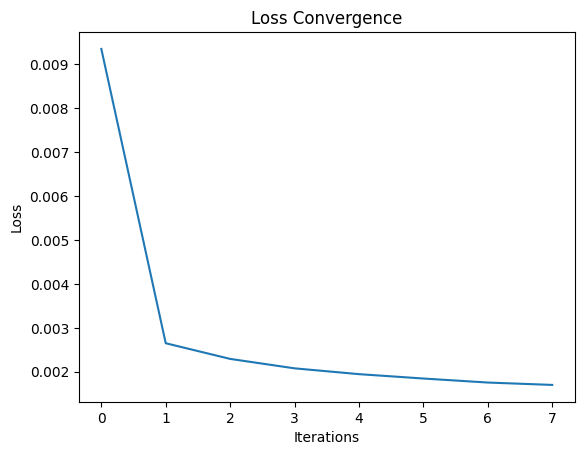

In [33]:
plt.plot(total_train_losses)
plt.title("Loss Convergence")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

In [60]:
bst_model_fpath = "./Data/bst_unet.pt"
os.makedirs(os.path.dirname(bst_model_fpath), exist_ok=True)
torch.save(model.train().state_dict(), bst_model_fpath)

In [30]:
model_test = UNet(
    num_classes=1,
    in_channels=3,
    depth=Params.unet_depth,
    start_filts=Params.unet_start_filters,
    merge_mode="concat",
)

if torch.__version__ >= "2.0.0":
    model_test = torch.compile(model_test)

In [31]:
model_test.load_state_dict(
    torch.load(f='./Data/bst_unet.pt', weights_only=True)
)
model_test.to(device).eval()  # change the model to evaluation mode to test

OptimizedModule(
  (_orig_mod): UNet(
    (conv_final): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
    (down_convs): ModuleList(
      (0): DownConv(
        (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): DownConv(
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (2): DownConv(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (3

### Testing

In [32]:
test_tfms = transforms.Compose(
    [
        transforms.Resize(Params.img_size),
        transforms.ToTensor(),
        transforms.Normalize(Params.channel_means, Params.channel_stds),
    ]
)

In [33]:
test_dl = DataLoader(
    ImgDataset(test_dpath, images_test, test_tfms),
    batch_size=Params.bs,
    pin_memory=Params.pin_memory,
    num_workers=Params.num_workers,
    shuffle=False,
)

In [34]:
submission = {"ImageId": [], "EncodedPixels": []}

for X, fnames in test_dl:
    with autocast(device_type=device):
        output = model_test(X.to(device))
    for i, fname in enumerate(fnames):
        mask = output[i]
        mask_sigmoid = torch.sigmoid(mask.squeeze())
        mask = mask_sigmoid > 0.2  # Thresholding to create a binary mask
        mask = Image.fromarray(mask.cpu().numpy().astype(np.uint8)).resize(
            original_img_size
        )
        mask = np.array(mask).astype(bool)
        labels = label(mask)  # `label` is imported correctly
        encodings = [rle_encode(labels == k) for k in np.unique(labels[labels > 0])]
        if len(encodings) > 0:
            for encoding in encodings:
                submission["ImageId"].append(fname)
                submission["EncodedPixels"].append(encoding)
        else:
            submission["ImageId"].append(fname)
            submission["EncodedPixels"].append(None)

In [35]:
submission_df = pd.DataFrame(submission, columns=["ImageId", "EncodedPixels"])
submission_df.to_csv('submission.csv', index=False)
submission_df

,ImageId,EncodedPixels
0,5e80f7077.jpg,None
1,d28f0f768.jpg,None
2,560ce7f5c.jpg,None
3,0ce0e895d.jpg,None
4,31b64a26e.jpg,80778 9 81546 9 82314 9 83079 15 83847 15 8461...
...,...,...
18145,7a9a0e3fd.jpg,None
18146,c985c87b6.jpg,None
18147,58d4f8b46.jpg,None
18148,d7071bea4.jpg,None


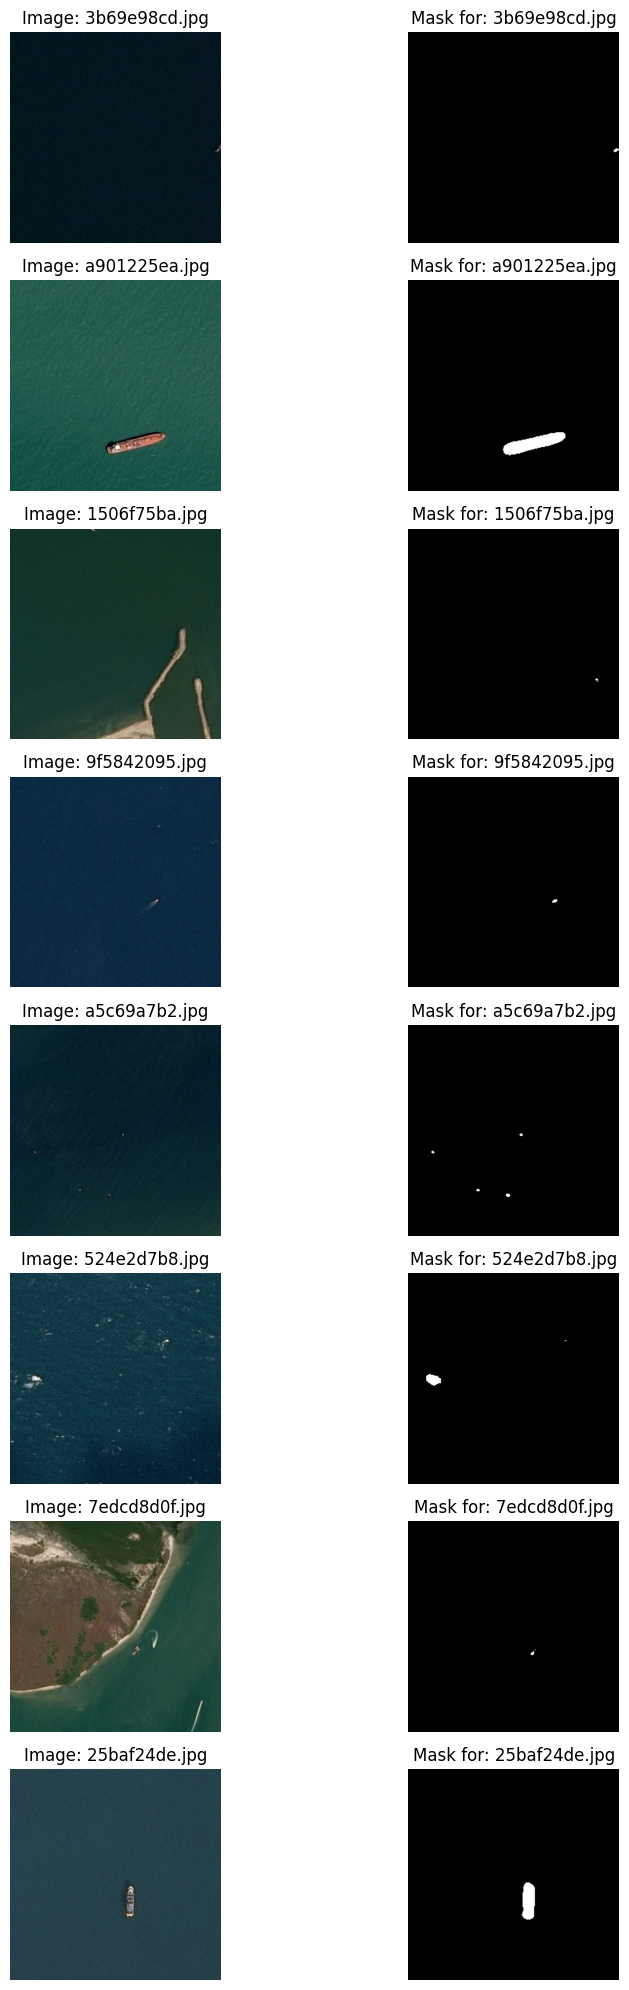

In [36]:
draw(
    "./Data/test_v2/",
    np.random.choice(
        [i for i in images_test if not is_empty(i, submission_df)], size=8
    ),
    submission_df,
    width,
    height,
    num_channels,
)

**Pregunta**: Más allá de la visualización, que métrica podrían utilizar para corroborar los resultados de la *U-Net*?

### Ejercicios:

1) Run-Length Encoding (RLE)

*¿Qué es Run-Length Encoding y para qué se utiliza?

* ¿Cómo se aplicaría RLE para comprimir la siguiente secuencia de píxeles: "AAAABBBCCDAA"?

* ¿Cuáles son las ventajas y desventajas de utilizar RLE en el contexto de la segmentación de imágenes?


2) Detección de Objetos

* Explica la diferencia entre la detección de objetos y la clasificación de imágenes.

* ¿Qué es un bounding box en el contexto de la detección de objetos?

* Menciona al menos dos métricas comunes utilizadas para evaluar modelos de detección de objetos.


3) U-Net

* Describe la estructura general de la arquitectura U-Net y su aplicación principal.
       
* ¿Cómo maneja U-Net el aprendizaje de características contextuales y locales?
    
* Proporciona un ejemplo de un problema que podría ser abordado eficazmente con U-Net fuera del ámbito médico.

4) **Mejorar el modelo en caso de ser posible. Aplicar una métrica acorde al problema.**

![Colegio Bourbaki](./Images/Matematicas.png)

![Contacto](./Images/Contacto.png)